In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
from torchvision import datasets, transforms

In [9]:
train = datasets.MNIST(
    './data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)
test = datasets.MNIST(
    './data', train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)

In [10]:
def plot(x):
    img = (np.array(x.detach().cpu(), dtype='float')).reshape(28, 28)
    
    plt.imshow(img, cmap='gray')
    plt.show()

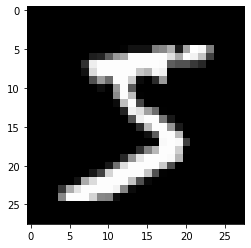

In [11]:
plot(train.data[0])

In [13]:
train.data.shape, test.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [16]:
train.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [93]:
x = train.data.float() / 255.
y = train.targets

# reshape
x = x.view(x.size(0), -1)
print(x.shape, y.shape)

input_size = x.size(-1)
output_size = int(max(y)) + 1

print('input_size: %d, output_size: %d' % (input_size, output_size))

torch.Size([60000, 784]) torch.Size([60000])
input_size: 784, output_size: 10


In [94]:
# train / valid split
ratios = [.8, .2]

train_cnt = int(x.size(0) * ratios[0])
valid_cnt = int(x.size(0) * ratios[1])
test_cnt = len(test.data)
cnts = [train_cnt, valid_cnt]

indices = torch.randperm(x.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

x += [(test.data.float() / 255.).view(test_cnt, -1)]
y += [test.targets]

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


In [95]:
model = nn.Sequential(
    nn.Linear(input_size, 500),
    nn.LeakyReLU(),
    nn.Linear(500, 400),
    nn.LeakyReLU(),
    nn.Linear(400, 300),
    nn.LeakyReLU(),
    nn.Linear(300, 200),
    nn.LeakyReLU(),
    nn.Linear(200, 100),
    nn.LeakyReLU(),
    nn.Linear(100, 50),
    nn.LeakyReLU(),
    nn.Linear(50, output_size),
    nn.LogSoftmax(dim=-1)
)

model

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=500, out_features=400, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=400, out_features=300, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=300, out_features=200, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=200, out_features=100, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=100, out_features=50, bias=True)
  (11): LeakyReLU(negative_slope=0.01)
  (12): Linear(in_features=50, out_features=10, bias=True)
  (13): LogSoftmax(dim=-1)
)

In [96]:
crit = nn.NLLLoss()

In [97]:
optimizer = optim.Adam(model.parameters())

In [98]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

In [99]:
model = model.to(device)

x = [x_i.to(device) for x_i in x]
y = [y_i.to(device) for y_i in y]

In [100]:
n_epochs = 1000
batch_size = 256
print_interval = 10

In [101]:
from copy import deepcopy

lowest_loss = np.inf
best_model = None

early_stop = 50
lowest_epoch = np.inf

In [102]:
train_history, valid_history = [], []

for i in range(n_epochs):
    indices = torch.randperm(x[0].size(0))
    
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    
    train_loss, valid_loss = 0, 0
    y_hat = []
    
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        # to one-hot
        loss = crit(y_hat_i, y_i.squeeze())
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        train_loss += float(loss)
    
    train_loss = train_loss / len(x_)
    
    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)
        
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i.squeeze())
            
            valid_loss += float(loss)
            
            y_hat += [y_hat_i]
    
    valid_loss = valid_loss / len(x_)
    
    train_history += [train_loss]
    valid_history += [valid_loss]
    
    if(i + 1) % print_interval == 0:
        print('Epoch %d: train_loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e' % 
              (i + 1,
               train_loss,
               valid_loss,
               lowest_loss))
    
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        
        best_model = deepcopy(model.state_dict())
        
    else :
        if (i + 1 - lowest_epoch) > early_stop and early_stop > 0 :
            print('Epoch stop : %d' % early_stop)
            break

print('The best validstion loss from epoch=%d, loss=%.4e' % (lowest_epoch + 1, lowest_loss))
model.load_state_dict(best_model)

Epoch 10: train_loss=2.6482e-02  valid_loss=1.0615e-01  lowest_loss=9.5335e-02
Epoch 20: train_loss=1.2682e-02  valid_loss=1.2209e-01  lowest_loss=9.5335e-02
Epoch 30: train_loss=8.8436e-03  valid_loss=1.1145e-01  lowest_loss=9.5335e-02
Epoch 40: train_loss=7.3662e-03  valid_loss=1.5155e-01  lowest_loss=9.5335e-02
Epoch 50: train_loss=6.3371e-03  valid_loss=1.2942e-01  lowest_loss=9.5335e-02
Epoch stop : 50
The best validstion loss from epoch=5, loss=9.5335e-02


<All keys matched successfully>

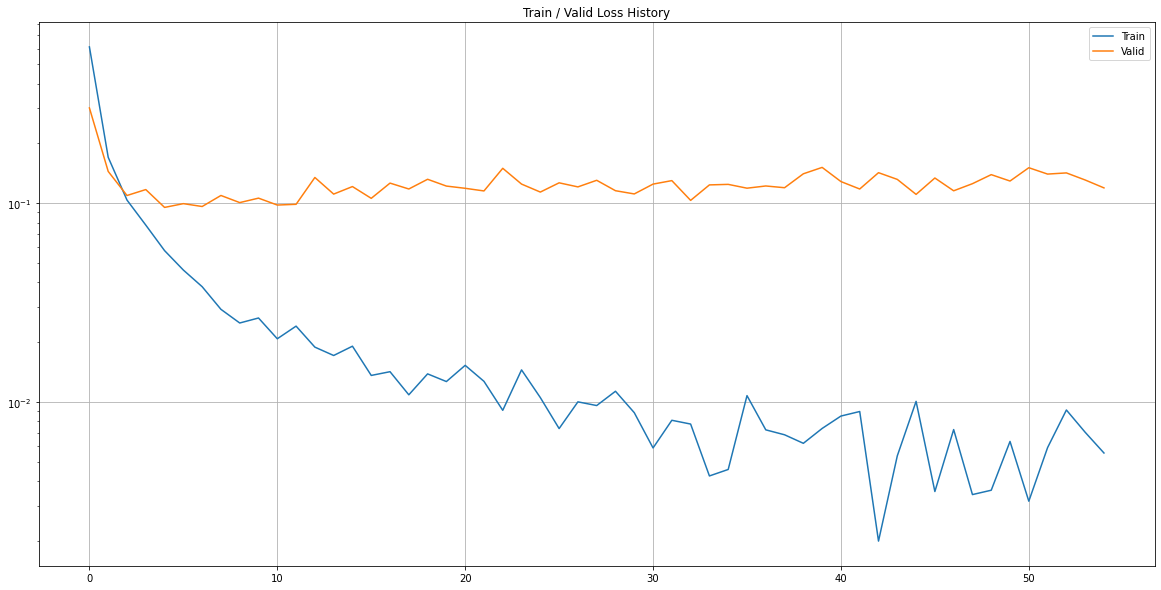

In [104]:
plot_from = 0

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title('Train / Valid Loss History')
plt.plot(range(plot_from, len(train_history)), train_history[plot_from:], label='Train')
plt.plot(range(plot_from, len(valid_history)), valid_history[plot_from:], label='Valid')
plt.yscale('log')
plt.legend()
plt.show()

In [105]:
test_loss = 0
y_hat = []

with torch.no_grad():
    x_ = x[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)
    
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())
        
        test_loss += float(loss)
        
        y_hat += [y_hat_i]
        
test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

print("Test loss: %.4e" % test_loss)

Test loss: 8.4844e-02


In [106]:
correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = float(y[-1].size(0))

print('Accuracy: %.4f' % (correct_cnt / total_cnt))

Accuracy: 0.9749


In [107]:
import pandas as pd
from sklearn.metrics import confusion_matrix

In [109]:
pd.DataFrame(confusion_matrix(y[-1], torch.argmax(y_hat, dim=-1)),
             index=['true_%d' % i for i in range(10)],
             columns=['pred_%d' % i for i in range(10)])

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0,970,0,1,0,1,2,3,1,2,0
true_1,0,1120,1,2,1,2,3,0,6,0
true_2,10,0,999,3,2,1,3,5,9,0
true_3,0,0,6,990,0,6,0,1,6,1
true_4,3,0,1,0,963,0,7,1,0,7
true_5,4,0,0,5,1,878,2,0,1,1
true_6,4,2,0,0,5,5,941,0,1,0
true_7,2,4,8,3,0,0,0,993,1,17
true_8,7,0,1,6,5,22,2,2,924,5
true_9,4,1,0,4,15,9,0,2,3,971
